# Project 01 - Color Compression


## **Thông tin sinh viên**


- Họ và tên: **Lê Phước Phát**
- MSSV: **22127322**
- Lớp: **22CLC10**


## **Import các thư viện liên quan**


In [62]:
import numpy as np  # import thu vien numpy (tinh toan ma tran)
from PIL import Image  # import thu vien pillow (doc, ghi anh)
import matplotlib.pyplot as plt  # import thu vien matplotlib (hien thi anh)
import os
import time # import thư viện time để tính toán thời gian chạy kmeans


## Helper functions


In [79]:
# Hàm đọc ảnh thông qua đường dẫn ảnh cho sẵn
def read_img(img_path):
    """
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    """
    # Kiểm tra xem kiểu đường dẫn ảnh đầu vào có phù hợp không.
    if not isinstance(img_path, str):
        raise ValueError('The provided path is not a string !!!')

    # Kiểm tra xem file có tồn tại hay không
    if not os.path.exists(img_path):
        raise FileNotFoundError('The specified image file does not exist !!!')

    try:
        # mở file ảnh để đọc
        with Image.open(img_path) as img:
            # sử dụng with statement để đảm bảo file được đóng đúng cách sau khi hoàn thành
            # type(img): <class 'PIL.JpegImagePlugin.JpegImageFile'>
            img_2d = np.array(img)  # chuyển đổi dạng list thành dạng numpy
    except Exception as e:
        raise IOError(f'An error occurred while reading the image: {e}') # hiển thị lỗi trong lúc đọc ảnh
    return img_2d  # trả về ma trận điểm ảnh dạng numpy 2D với img_2d.shape = (height, width, channels) với channels thường là 3.


# Ham hien thi anh
def show_img(img_2d):
    """
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    """
    # Kiểm tra xem img_2d có phải là mảng numpy (np.ndarray) hay không ?
    if not isinstance(img_2d, np.ndarray):
        raise ValueError("img_2d should be a numpy array")

    plt.figure(figsize=(8, 8))
    plt.title("Original Image")
    plt.imshow(img_2d)  # hiển thị hình ảnh 2D có shape là (height, width, channels)
    plt.axis("off")  # tắt trục => nhằm làm cho hình ảnh trông đẹp măt hơn.
    plt.show()  # hiển thị đồ thị chứa hình ảnh


# Hàm lưu ảnh có shape là (height, width, channels) vào đường dẫn ảnh mới img_path
def save_img(img_2d, img_path):
    """
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    """
    # Kiểm tra xem img_2d có phải là một mảng numpy hay không ?
    if not isinstance(img_2d, np.ndarray):
        raise ValueError('img_2d should be a numpy array')

    # Kiểm tra xem kiểu đường dẫn mới của ảnh có phù hợp không ?
    if not isinstance(img_path, str):
        raise ValueError("img_path should be a string")

    # Kiểm tra xem thư mục của đường dẫn có tồn tại hay không nếu không thì tạo thư mục đó
    directory = os.path.dirname(img_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    img = Image.fromarray(img_2d.astype('uint8'), 'RGB')  # Đọc ảnh từ np array
    img.save(img_path)


# Ham huyển đổi ảnh từ kích thước 2D (height, width, channels) sang 1D (height * width, channels)
def convert_img_to_1d(img_2d):
    """
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    """
    # Kiểm tra xem img_2d có phải là một mảng numpy và có đủ ba chiều (height, width, channels) không
    if not isinstance(img_2d, np.ndarray) or len(img_2d.shape) != 3:
        raise ValueError("img_2d should be a 3D numpy array with shape (height, width, channels)")

    height, width, channels = img_2d.shape  # lấy ra height, width, channels của ảnh 2D
    img_1d = img_2d.reshape(height * width, channels)  # chuyển đổi ảnh 2D thành ảnh 1D
    return img_1d


# Ham gom k_clusters nhóm màu => giảm số lượng màu bằng thuật toán K - Means
def kmeans(img_1d, k_clusters, max_iter, init_centroids="random"):
    """
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    """
    # Choose k random centroids
    # length = img_1d.shape[0] = height * width
    length = img_1d.shape[0]
    # dim = img_1d.shape[1] = channels
    dim = img_1d.shape[1]
    if init_centroids == "random":
        centers = np.random.randint(0, 256, size=(k_clusters, dim))
    elif init_centroids == "in_pixels":
        unique_pixels = np.unique(img_1d, axis=0)
        if len(unique_pixels) < k_clusters:
            raise ValueError("Not enough unique pixels to initialize centroids.")
        centers = unique_pixels[np.random.choice(unique_pixels.shape[0], size=k_clusters, replace=False)]
    else:
        raise ValueError("Invalid value for init_centroids. Use 'random' or 'in_pixels'.")

    start_time = time.time()
    while max_iter > 0:
        # Bước 01: tính khoảng cách của từng pixel đến centroid gần nhất
        distances = np.linalg.norm(img_1d[:, np.newaxis, :] - centers, axis=2)
        # Bước 02: tạo mảng labels chứa nhãn mỗi điểm trong tập img_1d
        labels = np.argmin(distances, axis=1)
        # Bước 03: Cập nhật centroids bằng np.mean
        centers_new = np.array([np.mean(img_1d[labels == k], axis = 0) for k in range(k_clusters)])
        # Bước 04: Kiểm tra điều kiện dừng
        if np.array_equal(centers, centers_new):
            break

        centers = centers_new

        max_iter -= 1
    end_time = time.time()
    durations = end_time - start_time

    return centers, labels, durations


# Ham tao anh moi tu cac mau trung tam (tu KMeans)
def generate_2d_img(img_2d_shape, centroids, labels):
    """
    Generate a 2D image based on K-means cluster centroids
    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)
    Returns
    -------
        New image (2D)
    """

    height, width, channels = img_2d_shape  # img_2d_shape (height, width, channels)

    img_1d = centroids[labels].astype(np.uint8)
    # centroids[labels] -> numpy su dung cac gia tri trong labels lam chi so de truy cap vao mang centroids
    # => moi gia tri trong 'labels' se duoc thay the bang mau sac trung binh tuong ung tu 'centroids'
    # astype(np.unit8) -> chuyen doi kieu du lieu cua mang ket qua ve kieu 'unit8' (unsigned 8-bit integer), la tieu chuan du lieu cua hinh anh (gia tri tu 0 - 255 cho moi kenh mau RGB)
    # centroids.shape = (k_clusters, num_channels) = (k_clusters, 3)
    # lables.shape = (height * width,) chua cac chi so cum cho moi pixel trong anh goc. Moi gia tri trong 'labels' la mot so nguyen tu '0' den 'k_clusters - 1'
    img_2d = img_1d.reshape((height, width, channels)
    ) # reshape hinh anh 1d thanh hinh anh 2d
    return img_2d

# Your additional functions here
# NONE


## **Your tests**


In [64]:
# Hàm in hình trong trường hợp test k = {3, 5, 7} (gồm 4 hình)
def show_multi_testing_pics(output_imgs, titles):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for ax, img, title in zip(axes, output_imgs, titles):
        ax.set_title(title)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [69]:
# Hàm testing
def testing(img_path, max_iter, initial_centroids):
    output_imgs = []
    titles = ['Original Image']
    k_values = [3, 5, 7]

    img_2d = read_img(img_path)
    output_imgs.append(img_2d)
    img_1d = convert_img_to_1d(img_2d)

    for k in k_values:
        centroids, labels, durations= kmeans(img_1d, k, max_iter, initial_centroids)
        new_img_2d = generate_2d_img(img_2d.shape, centroids, labels)
        output_imgs.append(new_img_2d)
        titles.append(f'{initial_centroids} with k = {k} \nTime: {durations:.4f} seconds')

    show_multi_testing_pics(output_imgs, titles)


## Main FUNCTION


In [80]:
# YOUR CODE HERE
def main():
    # Input parameters
    img_path = input("Enter the path of the image (use C:/): ")
    k_clusters = int(input("Enter the number of k clusters: "))
    max_iter = int(input("Enter the maximum number of iterations: "))
    centroidsT = int(input("Enter the initial centroids type (0 - random or 1 - in_pixels): "))

    if centroidsT == 0:
        centroid_type = 'random'
    elif centroidsT == 1:
        centroid_type = 'in_pixels'
    else:
        print('Invalid centroid initialization method')
        return

    # Open and read the image
    img_2d = read_img(img_path)
    # Convert the 2D image into 1D image
    img_1d = convert_img_to_1d(img_2d)

    # KMeans processing
    centroids, labels, durations = kmeans(img_1d, k_clusters, max_iter, centroid_type)

    print("Time processing: ", durations)

    # Generate the new 2D image
    new_img_2d = generate_2d_img(img_2d.shape, centroids, labels)

    # Processing the image name
    output_img = (img_path.split('/')[-1]).split('.')[0]
    directory_path = img_path.replace('/' + img_path.split('/')[-1], '')

    save_format = int(input('Enter output file type (0 - PNG, 1 - JPG, 2 - PDF): '))

    if save_format == 0:
        save_path = f"{directory_path}/{output_img}_{centroid_type}_{k_clusters}_generated.png"
    elif save_format == 1:
        save_path = f"{directory_path}/{output_img}_{centroid_type}_{k_clusters}_generated.jpg"
    elif save_format == 2:
        save_path = f"{directory_path}/{output_img}_{centroid_type}_{k_clusters}_generated.pdf"
    else:
        print('Invalid save format.')
        return

    # Save the generated image
    save_img(new_img_2d, save_path)
    print(f"New image saved successfully at {save_path}")

    # show_img
    show_img(new_img_2d)


Enter the path of the image (use C:/): /content/hinh-thien-nhien-3d-002.jpg
Enter the number of k clusters: 3
Enter the maximum number of iterations: 10
Enter the initial centroids type (0 - random or 1 - in_pixels): 1
Time processing:  0.8993897438049316
Enter output file type (0 - PNG, 1 - JPG, 2 - PDF): 2
New image saved successfully at /content/hinh-thien-nhien-3d-002_in_pixels_3_generated.pdf


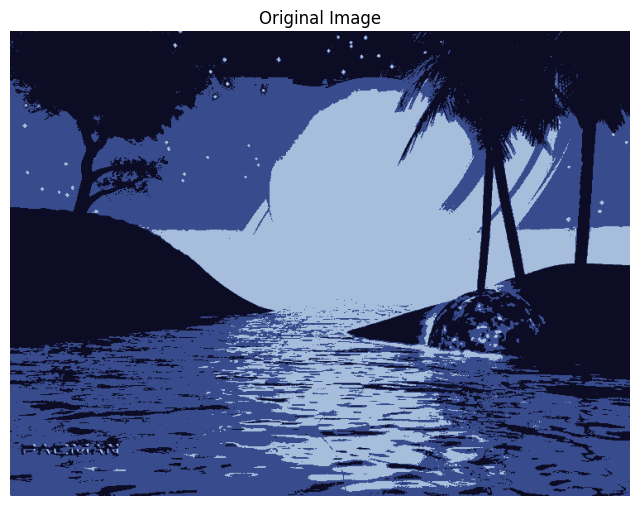

In [81]:
# Call main function
if __name__ == "__main__":
    main()
